In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [24]:
zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

weather = pd.read_csv('weather.csv', index_col = 0,
                   parse_dates=['Time']
                  )

sales_tax = pd.read_csv('sales_tax_allocation.csv', index_col = 0,
                   parse_dates=['Time']
                  )

shiller = pd.read_csv('sap_case_shiller.csv', index_col = 0,
                   parse_dates=['Time']
                  )

polls = pd.read_csv('poll_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )

monthly_tnx = pd.read_csv('monthly_tnx.csv', index_col = 0,
                   parse_dates=['Time']
                  )

gas = pd.read_csv('monthly_avg_gas_prices.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# liquor = pd.read_csv('liquor_permit.csv', index_col = 0,
#                    parse_dates=['Time']
#                   )

# env = pd.read_csv('env_violation.csv', index_col = 0,
#                    parse_dates=['Time']
#                   )

# daycare = pd.read_csv('daycare.csv', index_col = 0,
#                    parse_dates=['Time']
#                   )

covid = pd.read_csv('covid_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )

unemployment = pd.read_csv('city_unemployment_rates.csv', index_col = 0,
                   parse_dates=['Time']
                  )

census = pd.read_csv('acs_master11to18_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )

econ = pd.read_csv('key_econ.csv', index_col = 0,
                   parse_dates=['Time']
                  )

taxpayer = pd.read_csv('new_biz_taxpayer.csv', index_col = 0,
                   parse_dates=['Time']
                  )

outlet = pd.read_csv('new_biz_outlet.csv', index_col = 0,
                   parse_dates=['Time']
                  )

In [25]:
df_dict = {'zri':zri, 'weather':weather, 'sales_tax':sales_tax, 
           'shiller':shiller, 'polls':polls, 'monthly_tnx':monthly_tnx, 
           'gas':gas, 
#            'liquor':liquor, 'env':env, 'daycare':daycare, 
           'covid':covid, 
           'unemployment':unemployment, 'census':census, 'econ':econ, 'taxpayer':taxpayer, 'outlet':outlet}
for df in df_dict.keys():
    print('\n'+df+'===================')
    print(df_dict[df].head())
    date_range = str(df_dict[df]['Time'].dt.date.min()) + ' to ' +str(df_dict[df]['Time'].dt.date.max())
    print(f'{df}: {date_range}')
    df_columns = str(list(df_dict[df].columns))
    print(f'{df} columns: {df_columns}')


zri===================
        Time  zip_code  zori_ssa
0 2014-01-01     77494    1390.0
1 2014-02-01     77494    1387.0
2 2014-03-01     77494    1384.0
3 2014-04-01     77494    1381.0
4 2014-05-01     77494    1379.0
zri: 2014-01-01 to 2021-07-01
zri columns: ['Time', 'zip_code', 'zori_ssa']

weather===================
        Time  zip_code  mintempC   maxtempC  precipMM
0 2012-01-01     78727  6.806452  16.967742  2.419355
1 2012-01-01     78759  6.806452  16.967742  2.419355
2 2012-01-01     78681  6.806452  16.967742  2.419355
3 2012-01-01     78728  6.806452  16.967742  2.419355
4 2012-01-01     78634  6.806452  16.967742  2.419355
weather: 2012-01-01 to 2021-08-01
weather columns: ['Time', 'zip_code', 'mintempC', 'maxtempC', 'precipMM']

sales_tax===================
           Time  zip_code  sales_tax_rate  total_sales_tax  \
2580 2013-01-01     77494             1.0        832941.14   
2581 2013-01-01     77449             1.0        832941.14   
2582 2013-01-01     77084 

In [5]:
# wow census is 10000% bigger than we were treating it. lol

# ['zip_code', 'male_pop', 'female_pop', 
#  'median_age', 'white_pop', 'not_us_citizen_pop', 
#  'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop', 
#  'other_race_pop', 'median_income', 'income_per_capita', 
#  'pop_determined_poverty_status', 'poverty', 'gini_index', 'housing_units', 
#  'renter_occupied_housing_units_paying_cash_median_gross_rent', 'occupied_housing_units', 
#  'vacant_housing_units_for_rent', 'median_year_structure_built', 'married_households', 
#  'households_public_asst_or_food_stamps', 'male_male_households', 'female_female_households', 
#  'children', 'median_rent', 'percent_income_spent_on_rent', 'owner_occupied_housing_units', 
#  'aggregate_travel_time_to_work', 'commuters_by_public_transportation', 'high_school_diploma', 
#  'bachelors_degree', 'employed_pop', 'unemployed_pop', 'pop_in_labor_force', 
#  'armed_forces', 'year', 'Time']

In [59]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    6:['zori_ssa'],
    7:['zori_ssa'],
    8:['zori_ssa'],
    9:['zori_ssa'],
    10:['zori_ssa'],
    11:['zori_ssa'],
    12:['zori_ssa'],
},
                                          return_cols = True
                                         )
# weather 
zri_shift, weather_X_vals = helper.time_lag_merge(zri_shift, weather, {
    6:['mintempC', 'maxtempC', 'precipMM'],
    12:['mintempC', 'maxtempC', 'precipMM'],
},
                                          return_cols = True
                                         )
# sales_tax
zri_shift, sales_tax_X_vals = helper.time_lag_merge(zri_shift, sales_tax, {
    5:['per_diff_total_sales_tax'],
    6:['per_diff_total_sales_tax'],
    12:['per_diff_total_sales_tax'],
},
                                          return_cols = True
                                         )

# shiller
zri_shift, shiller_X_vals = helper.time_lag_merge(zri_shift, shiller, {
    7:['sap_case_shiller_index', 'delta_sap_case_shiller_index'],
    12:['sap_case_shiller_index', 'delta_sap_case_shiller_index'],
},
                                          return_cols = True
                                         )

# polls
zri_shift, polls_X_vals = helper.time_lag_merge(zri_shift, polls, {
    6:['tx_is_a_lot_better', 'tx_is_a_little_better', 'tx_is_abt_same', 
        'tx_is_a_little_worse', 'tx_is_a_lot_worse', 'tx_is_dont_know', 
        'tx_is_better', 'tx_is_worse'],
    12:['tx_is_a_lot_better', 'tx_is_a_little_better', 'tx_is_abt_same', 
        'tx_is_a_little_worse', 'tx_is_a_lot_worse', 'tx_is_dont_know', 
        'tx_is_better', 'tx_is_worse'],
},
                                          return_cols = True
                                         )

# monthly_tnx
zri_shift, monthly_tnx_X_vals = helper.time_lag_merge(zri_shift, monthly_tnx, {
    5:['TNX', 'delta_TNX'],
    6:['TNX', 'delta_TNX'],
    12:['TNX', 'delta_TNX'],
},
                                          return_cols = True
                                         )

# gas
zri_shift, gas_X_vals = helper.time_lag_merge(zri_shift, gas, {
    5:['monthly_avg_gas_price', 'delta_monthly_avg_gas_price',],
    6:['monthly_avg_gas_price', 'delta_monthly_avg_gas_price',],
    12:['monthly_avg_gas_price', 'delta_monthly_avg_gas_price',],
},
                                          return_cols = True
                                         )

# covid
zri_shift, covid_X_vals = helper.time_lag_merge(zri_shift, covid, {
    5:['fatalities', 'caseCount'],
    6:['fatalities', 'caseCount'],
    12:['fatalities', 'caseCount'],
},
                                          return_cols = True
                                         )

# unemployment
zri_shift, unemployment_X_vals = helper.time_lag_merge(zri_shift, unemployment, {
    6:['ur', 'delta_ur'],
    12:['ur', 'delta_ur'],
},
                                          return_cols = True
                                         )

# census
zri_shift, census_X_vals = helper.time_lag_merge(zri_shift, 
                                                 census.dropna(axis='columns',how = 'any'
                                                                 ).reset_index(drop = True), {
    43:['male_pop', 'female_pop', 
 'median_age', 'white_pop', 'not_us_citizen_pop', 
 'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop', 
 'other_race_pop', 'median_income', 'income_per_capita', 
 'pop_determined_poverty_status', 'poverty', 'gini_index', 'housing_units', 
 'renter_occupied_housing_units_paying_cash_median_gross_rent', 'occupied_housing_units', 
 'vacant_housing_units_for_rent', 'median_year_structure_built', 'married_households', 
 'households_public_asst_or_food_stamps', 'male_male_households', 'female_female_households', 
 'children', 'median_rent', 'percent_income_spent_on_rent', 'owner_occupied_housing_units', 
 'commuters_by_public_transportation', 'employed_pop', 'unemployed_pop', 'pop_in_labor_force', 
 'armed_forces'],
#     24:['male_pop', 'female_pop', 
#  'median_age', 'white_pop', 'not_us_citizen_pop', 
#  'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop', 
#  'other_race_pop', 'median_income', 'income_per_capita', 
#  'pop_determined_poverty_status', 'poverty', 'gini_index', 'housing_units', 
#  'renter_occupied_housing_units_paying_cash_median_gross_rent', 'occupied_housing_units', 
#  'vacant_housing_units_for_rent', 'median_year_structure_built', 'married_households', 
#  'households_public_asst_or_food_stamps', 'male_male_households', 'female_female_households', 
#  'children', 'median_rent', 'percent_income_spent_on_rent', 'owner_occupied_housing_units', 
#  'commuters_by_public_transportation', 'employed_pop', 'unemployed_pop', 'pop_in_labor_force', 
#  'armed_forces'],
},
                                          return_cols = True
                                         )

# econ
zri_shift, econ_X_vals = helper.time_lag_merge(zri_shift, econ, {
    6:['Consumer Confidence Index TX', 'Consumer Confidence West South Central', 
     'Consumer Confidence Index US', 'Consumer Price Index TX', 
     'Consumer Price Index U.S.', 'Nonfarm Employment TX', 'Nonfarm Employment U.S.', 
     'Unemployment TX', 'Unemployment U.S.', 'Single Family Building Permits TX', 
     'Multi Family Building Permits TX', 'Existing Single Family Home Sales TX', 
     'Existing Single Family Home Price TX', 'Non Residential Building Construction', 
     'Total Sales Tax Collections Retail TX', 'Total Sales Tax Collections TX', 'Retail Gasoline Price TX', 
     'Retail Diesel Price TX', 'Nonfarm Employment Illinois', 'Nonfarm Employment Florida', 
     'Nonfarm Employment New York', 'Nonfarm Employment Texas', 'Nonfarm Employment California', 
     'Gross Value Crude Oil Production', 'Gross Value Natural Gas Production', 
     'Motor Fuel Taxed Gasoline', 'Motor Fuel Taxed Diesel'],
    12:['Consumer Confidence Index TX', 'Consumer Confidence West South Central', 
     'Consumer Confidence Index US', 'Consumer Price Index TX', 
     'Consumer Price Index U.S.', 'Nonfarm Employment TX', 'Nonfarm Employment U.S.', 
     'Unemployment TX', 'Unemployment U.S.', 'Single Family Building Permits TX', 
     'Multi Family Building Permits TX', 'Existing Single Family Home Sales TX', 
     'Existing Single Family Home Price TX', 'Non Residential Building Construction', 
     'Total Sales Tax Collections Retail TX', 'Total Sales Tax Collections TX', 'Retail Gasoline Price TX', 
     'Retail Diesel Price TX', 'Nonfarm Employment Illinois', 'Nonfarm Employment Florida', 
     'Nonfarm Employment New York', 'Nonfarm Employment Texas', 'Nonfarm Employment California', 
     'Gross Value Crude Oil Production', 'Gross Value Natural Gas Production', 
     'Motor Fuel Taxed Gasoline', 'Motor Fuel Taxed Diesel'],
},
                                          return_cols = True
                                         )

# taxpayer
zri_shift, taxpayer_X_vals = helper.time_lag_merge(zri_shift, taxpayer, {
    6:['taxpayer_count',  'taxpayer_same_zip_ratio', 
 'taxpayer_cl_ratio', 'taxpayer_is_ratio', 'taxpayer_foreign_ratio'],
    12:['taxpayer_count',  'taxpayer_same_zip_ratio', 
 'taxpayer_cl_ratio', 'taxpayer_is_ratio', 'taxpayer_foreign_ratio'],
},
                                          return_cols = True
                                         )

# outlet
zri_shift, outlet_X_vals = helper.time_lag_merge(zri_shift, outlet, {
    6:['outlet_count', 'outlet_non_tx_ratio', 
 'outlet_cl_ratio', 'outlet_is_ratio', 'outlet_foreign_ratio'],
    12:['outlet_count', 'outlet_non_tx_ratio', 
 'outlet_cl_ratio', 'outlet_is_ratio', 'outlet_foreign_ratio'],
},
                                          return_cols = True
                                         )


In [7]:
# our X vals are the same lengths as the zri_shift.columns plus the number of drop columns

In [46]:
zri_shift.columns

X_vals = (zri_shift_X_vals + weather_X_vals + sales_tax_X_vals + shiller_X_vals + polls_X_vals + 
            monthly_tnx_X_vals + gas_X_vals + covid_X_vals + unemployment_X_vals + 
            econ_X_vals + taxpayer_X_vals + outlet_X_vals+ census_X_vals)
drop_cols = ['Time', 'zip_code', 'zori_ssa']
print(f'len of X_vals: {len(X_vals)}')
print(f'len of zri_shift.columns: {len(zri_shift.columns)}')

len of X_vals: 165
len of zri_shift.columns: 168


In [9]:
# the missing values are all within our target variable being shifted 6-12 months. that is an acceptable loss

In [39]:
list(zri_shift.columns)

['Time',
 'zip_code',
 'zori_ssa',
 'zori_ssa_6_month_shift',
 'zori_ssa_7_month_shift',
 'zori_ssa_8_month_shift',
 'zori_ssa_9_month_shift',
 'zori_ssa_10_month_shift',
 'zori_ssa_11_month_shift',
 'zori_ssa_12_month_shift',
 'mintempC_6_month_shift',
 'maxtempC_6_month_shift',
 'precipMM_6_month_shift',
 'mintempC_12_month_shift',
 'maxtempC_12_month_shift',
 'precipMM_12_month_shift',
 'per_diff_total_sales_tax_5_month_shift',
 'per_diff_total_sales_tax_6_month_shift',
 'per_diff_total_sales_tax_12_month_shift',
 'sap_case_shiller_index_7_month_shift',
 'delta_sap_case_shiller_index_7_month_shift',
 'sap_case_shiller_index_12_month_shift',
 'delta_sap_case_shiller_index_12_month_shift',
 'tx_is_a_lot_better_6_month_shift',
 'tx_is_a_little_better_6_month_shift',
 'tx_is_abt_same_6_month_shift',
 'tx_is_a_little_worse_6_month_shift',
 'tx_is_a_lot_worse_6_month_shift',
 'tx_is_dont_know_6_month_shift',
 'tx_is_better_6_month_shift',
 'tx_is_worse_6_month_shift',
 'tx_is_a_lot_better

In [48]:
zri_shift.loc[zri_shift['male_pop_43_month_shift'].isna(),'Time'].dt.date.min()

datetime.date(2014, 1, 1)

In [49]:
zri_shift.loc[zri_shift['male_pop_43_month_shift'].isna(),'Time'].dt.date.max()

datetime.date(2021, 7, 1)

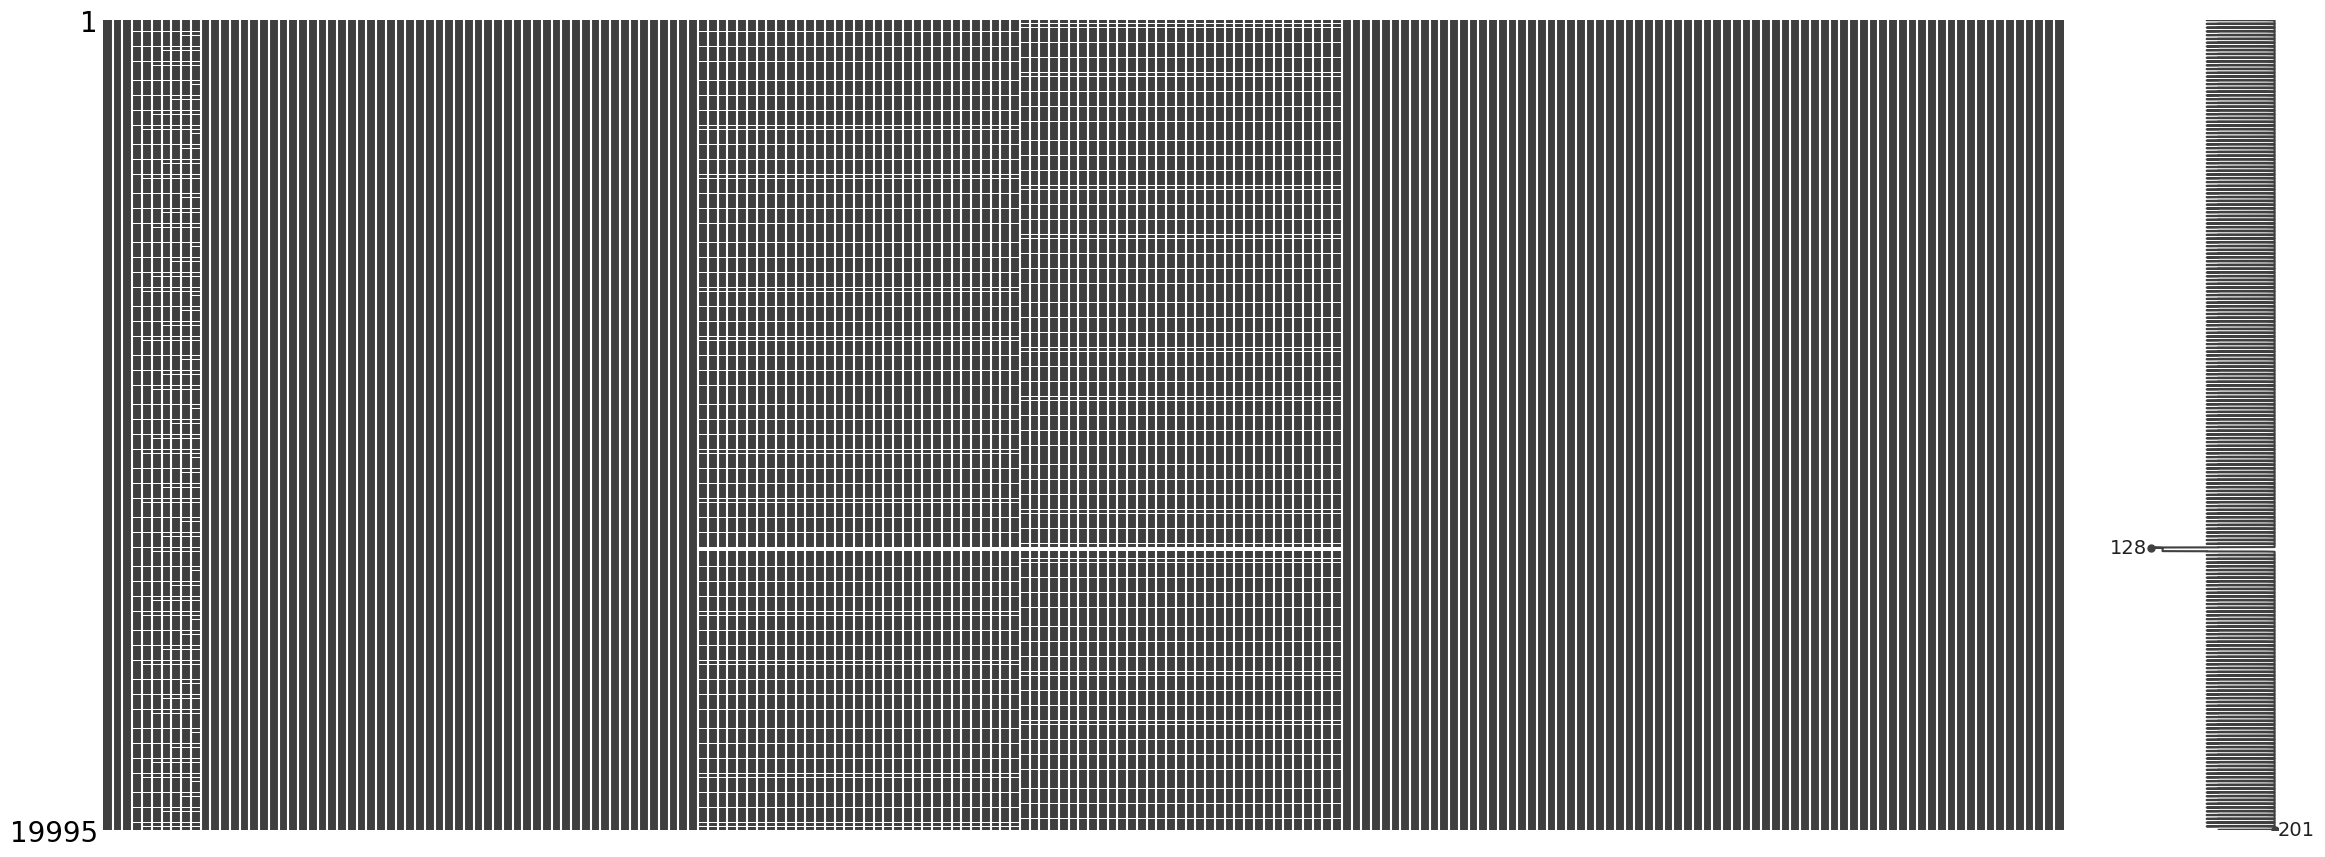

In [58]:
msno.matrix(zri_shift)
plt.show()

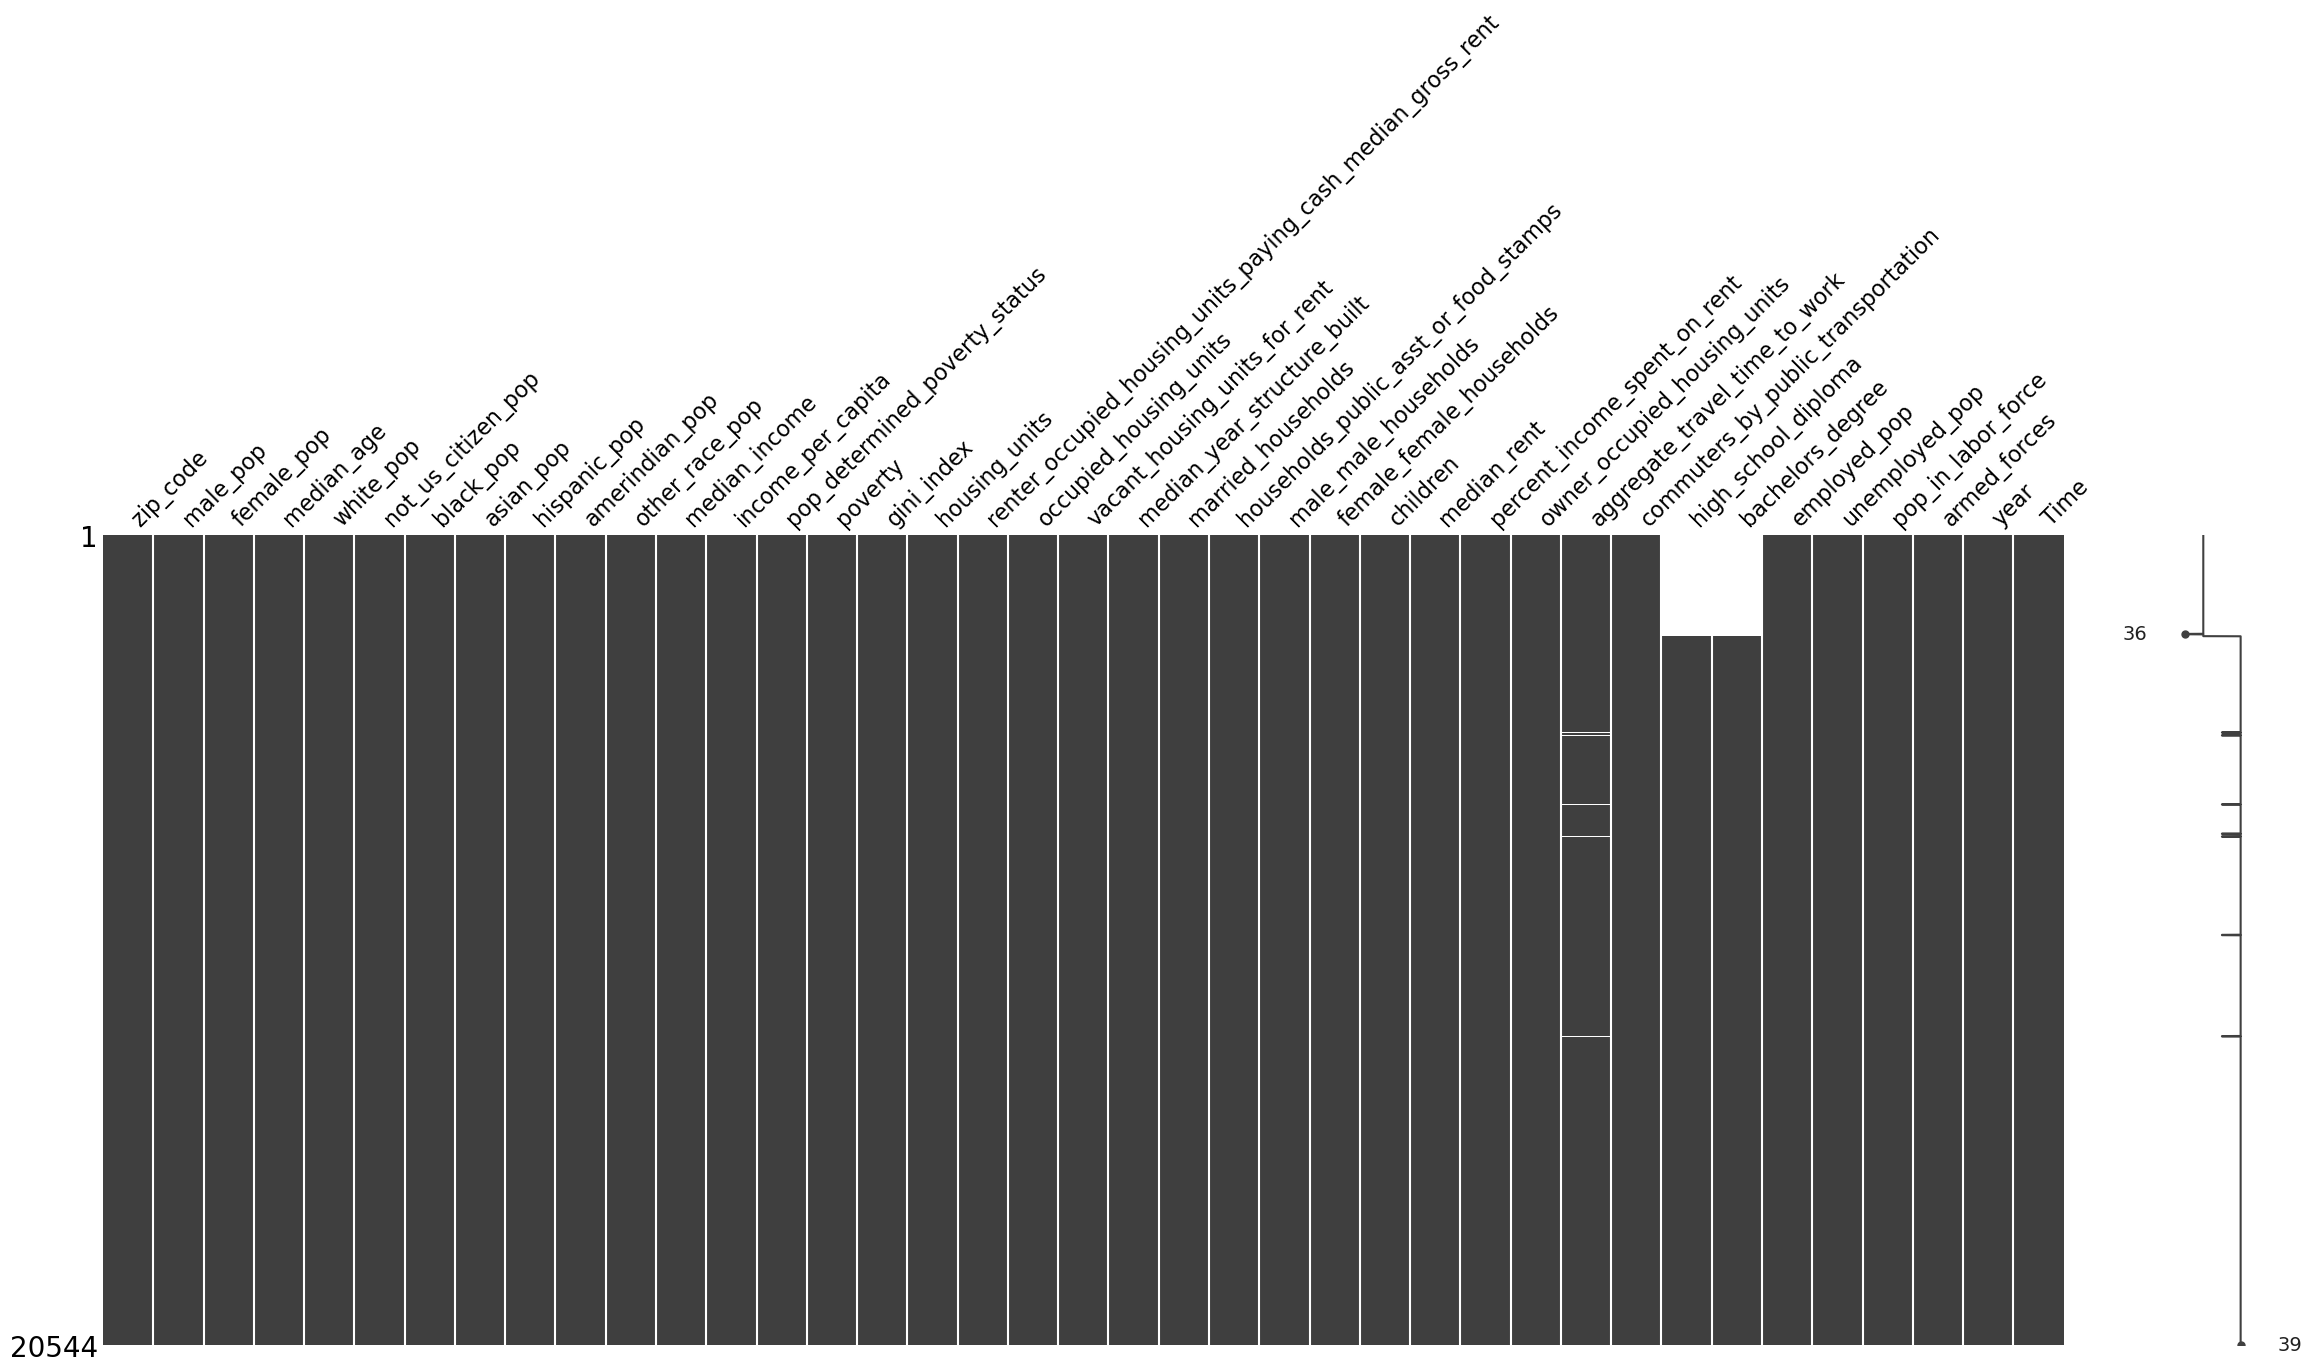

In [31]:
msno.matrix(census)
plt.show()

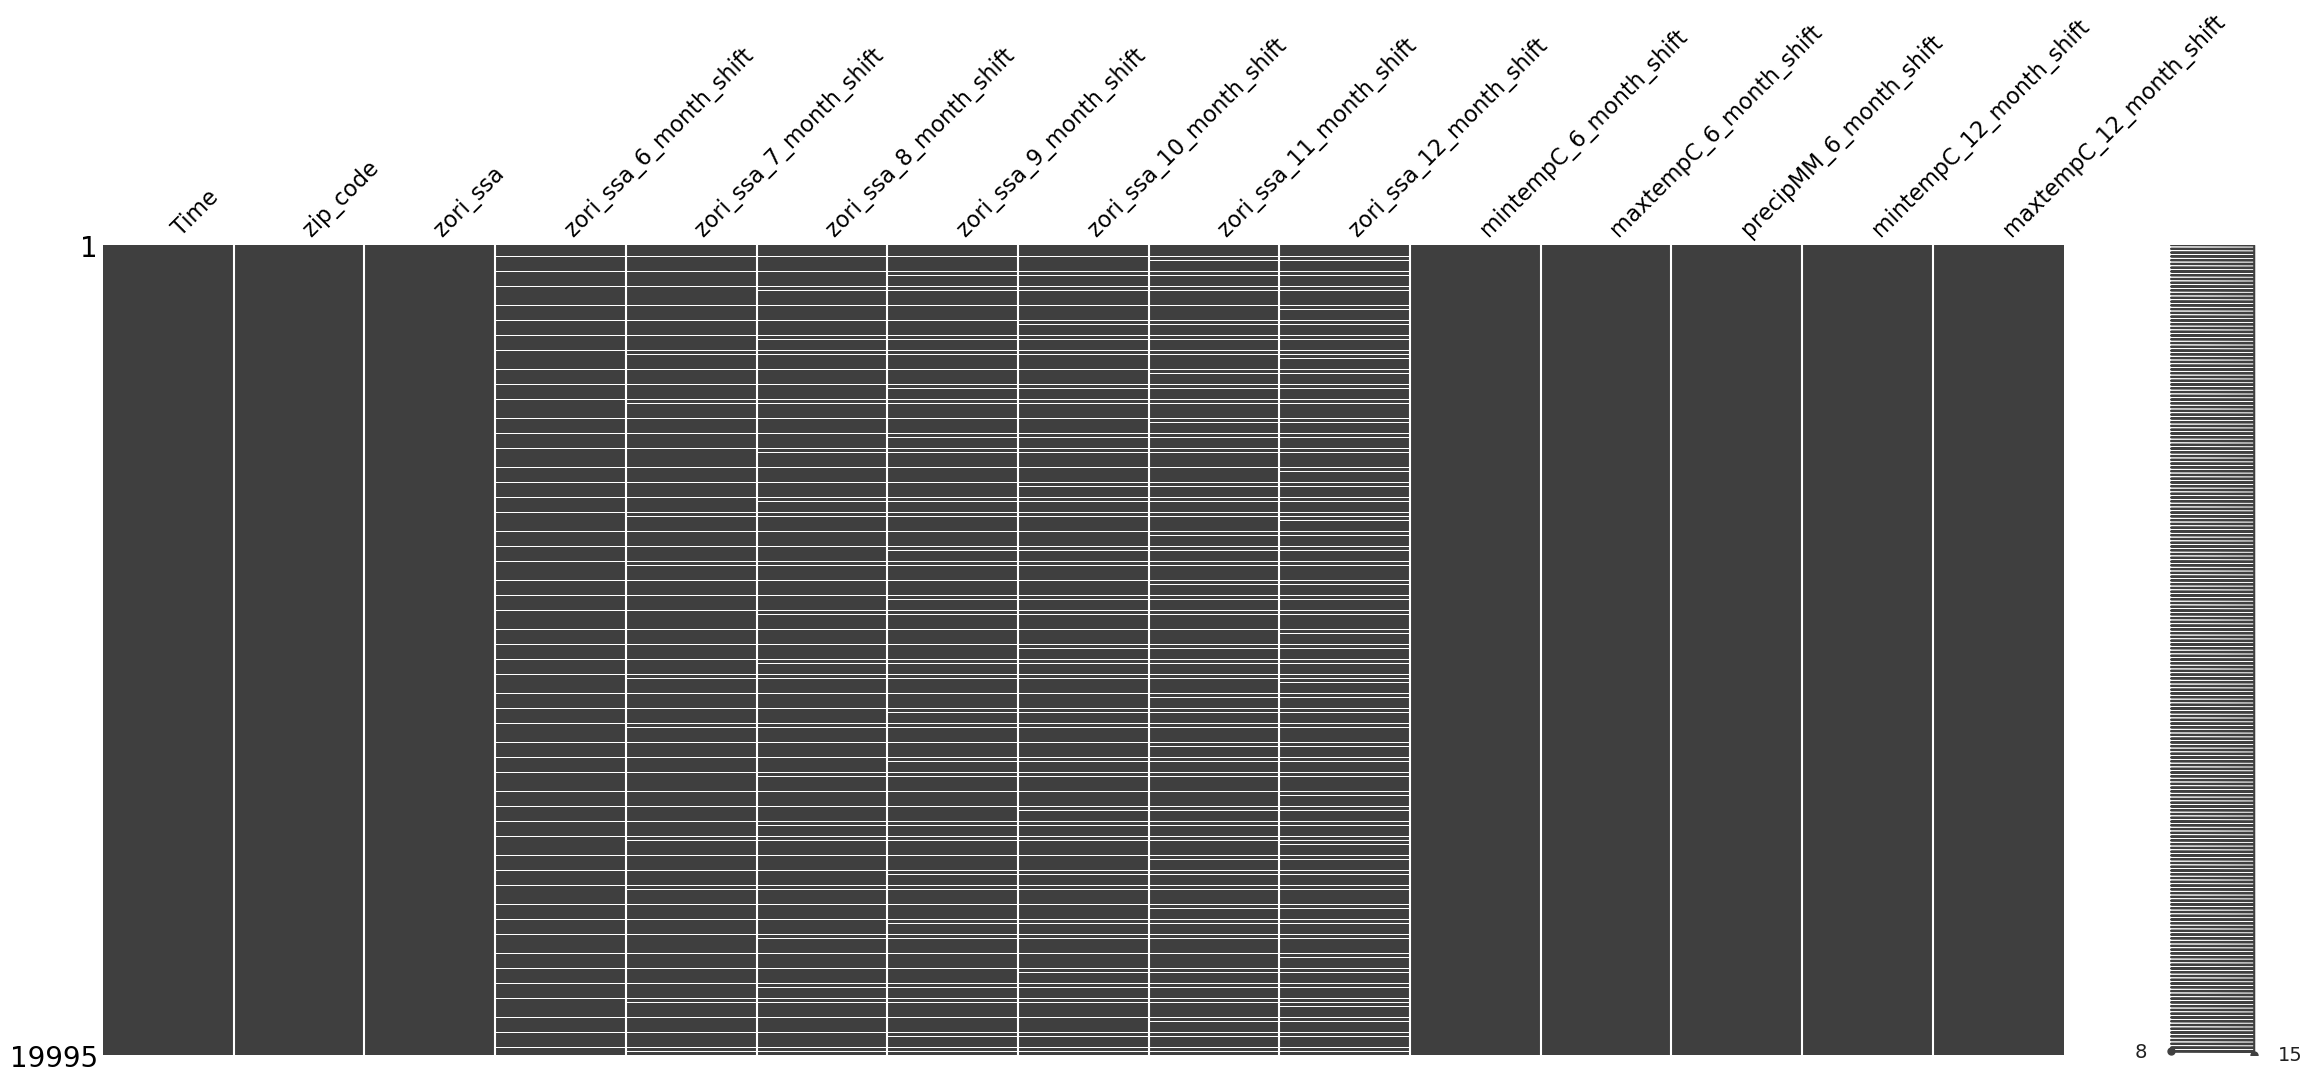

In [30]:
msno.matrix(zri_shift.iloc[:,0:15])
plt.show()

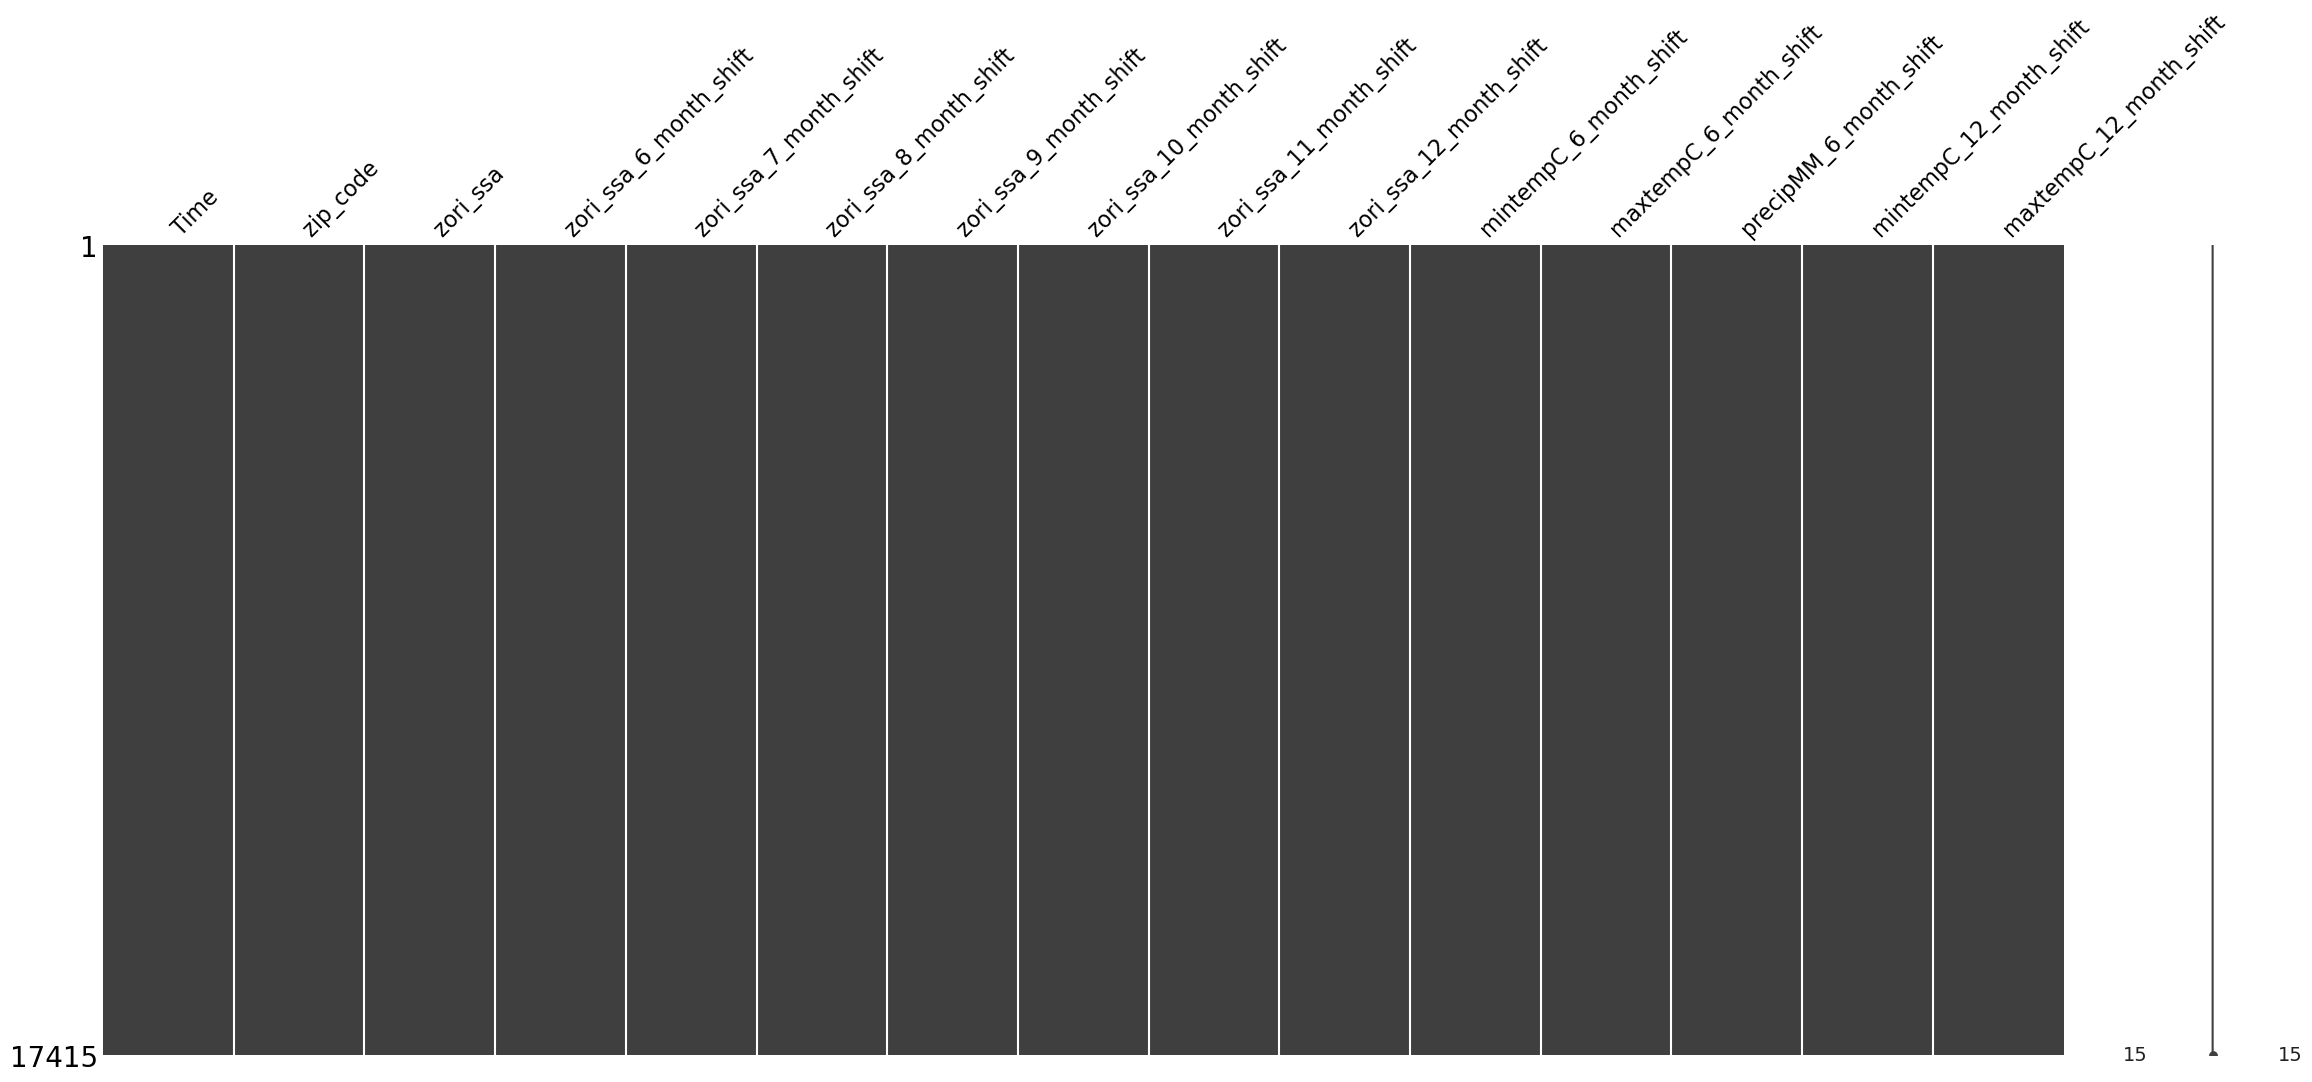

In [12]:
msno.matrix(zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True).iloc[:,0:15])
plt.show()

In [60]:
# need to drop the missing values created from the date lagging.
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)

y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted

Performing Grid Search with alphas of: [0.3, 0.6, 1]


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


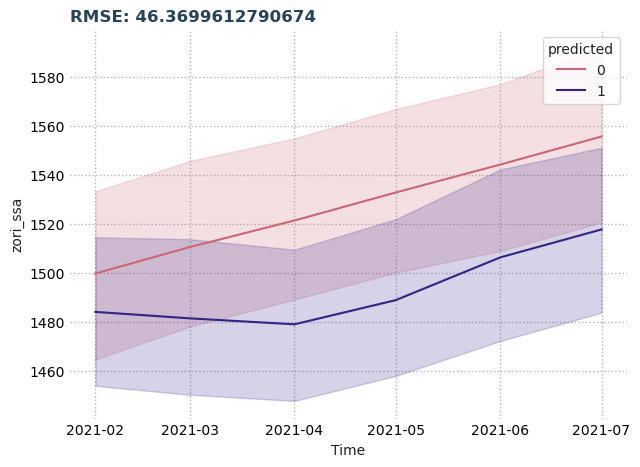

In [61]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

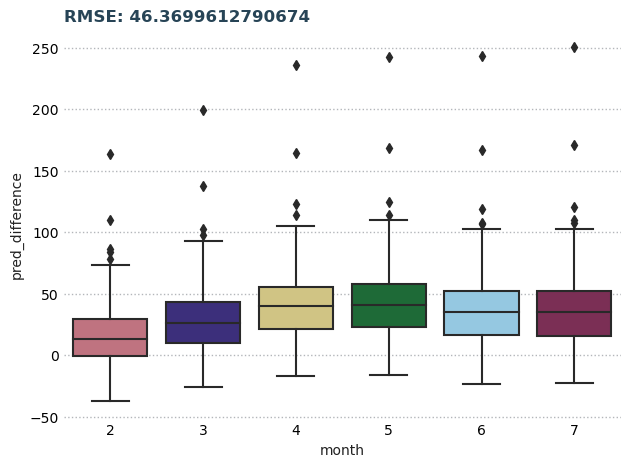

In [62]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
#                  hue = 'pred_difference'
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [63]:
clf.best_score_

-15.648789089176114

In [64]:
clf.best_params_

{'alpha': 0.3}

In [65]:
clf.best_estimator_.coef_

array([ 0.00000000e+00,  2.44164511e+02, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.40840986e+00,
       -4.53047667e-01, -1.96842950e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  4.18796831e-01,  6.98303410e-01,  5.57125654e-03,
        0.00000000e+00,  0.00000000e+00,  1.00594689e+00,  6.67691887e-01,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -8.94775597e-02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [66]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_6_month_shift,244.164511,244.164511
1,Nonfarm Employment New York_6_month_shift,-4.371576,4.371576
2,income_per_capita_43_month_shift,-4.199213,4.199213
3,children_43_month_shift,2.003594,2.003594
4,mintempC_6_month_shift,-1.968429,1.968429
5,median_year_structure_built_43_month_shift,-1.918435,1.918435
6,hispanic_pop_43_month_shift,-1.771397,1.771397
7,commuters_by_public_transportation_43_month_shift,-1.644393,1.644393
8,housing_units_43_month_shift,-1.438510,1.438510
9,maxtempC_12_month_shift,-1.408410,1.408410


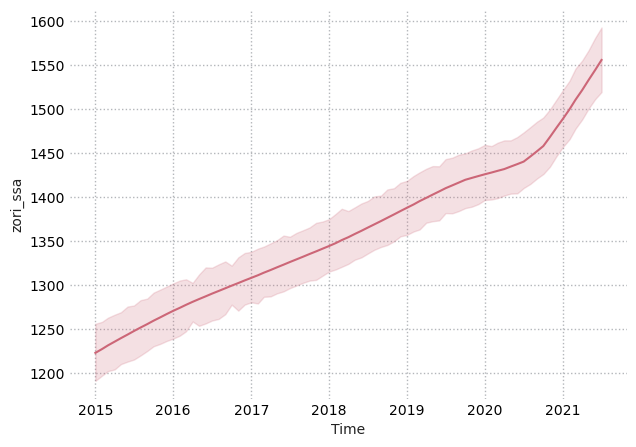

In [20]:
sns.lineplot(data = zri_shift, y = 'zori_ssa', x= 'Time')
plt.show()

In [21]:
X_vals

['zori_ssa_7_month_shift',
 'zori_ssa_6_month_shift',
 'zori_ssa_12_month_shift',
 'zori_ssa_8_month_shift',
 'zori_ssa_10_month_shift',
 'zori_ssa_11_month_shift',
 'zori_ssa_9_month_shift',
 'maxtempC_12_month_shift',
 'mintempC_12_month_shift',
 'mintempC_6_month_shift',
 'maxtempC_6_month_shift',
 'precipMM_12_month_shift',
 'precipMM_6_month_shift',
 'per_diff_total_sales_tax_6_month_shift',
 'per_diff_total_sales_tax_5_month_shift',
 'per_diff_total_sales_tax_12_month_shift',
 'sap_case_shiller_index_7_month_shift',
 'sap_case_shiller_index_12_month_shift',
 'delta_sap_case_shiller_index_12_month_shift',
 'delta_sap_case_shiller_index_7_month_shift',
 'tx_is_a_lot_better_6_month_shift',
 'tx_is_worse_6_month_shift',
 'tx_is_dont_know_6_month_shift',
 'tx_is_dont_know_12_month_shift',
 'tx_is_a_little_better_6_month_shift',
 'tx_is_a_lot_worse_6_month_shift',
 'tx_is_a_little_worse_12_month_shift',
 'tx_is_better_6_month_shift',
 'tx_is_a_lot_better_12_month_shift',
 'tx_is_a_lot_

In [23]:
# need to drop the missing values created from the date lagging.
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)

y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.1, 0.3]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

Performing Grid Search with alphas of: [0.1, 0.3]


KeyboardInterrupt: 

In [ ]:
g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
#                  hue = 'pred_difference'
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df